In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
# inline plotting
%matplotlib inline

In [3]:
import sys
sys.path.append("../../")
from labproject.experiments import Experiment, ScaleDim, ScaleSampleSize
from labproject.utils import get_log_path

In [4]:
from labproject.data import DATASETS, DISTRIBUTIONS
from labproject.metrics import METRICS
from torch.distributions import MultivariateNormal
METRICS.keys()


dict_keys(['mmd_rbf', 'mmd_rbf_median_heuristic', 'mmd_rbf_auto', 'mmd_polynomial', 'mmd_linear_naive', 'mmd_linear', 'c2st_nn', 'c2st_rf', 'c2st_knn', 'gaussian_kl_divergence', 'wasserstein_gauss_squared', 'sliced_wasserstein', 'wasserstein_kuhn', 'wasserstein_sinkhorn'])

In [5]:
from labproject.plotting import generate_palette
color_dict = {"wasserstein": "#cc241d",
              "mmd": "#eebd35",
              "c2st": "#458588",
              "fid": "#8ec07c", 
              "kl": "#8ec07c"}


col_map = {'ScaleSampleSizeKL':'kl', 'ScaleSampleSizeSW':'wasserstein',
           'ScaleSampleSizeMMD':'mmd', 'ScaleSampleSizeC2ST':'c2st',
           'ScaleSampleSizeFID':'fid', 'ScaleDimKL':'kl', 'ScaleDimSW':'wasserstein',
           'ScaleDimMMD':'mmd', 'ScaleDimC2ST':'c2st', 'ScaleGammaMMD':'mmd',
           'ScaleDimFID':'fid',}


# All multiple datasets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Running experiments...
Seed: 0
Experiments: ['ScaleGammaMMD', 'ScaleGammaMMD', 'ScaleGammaMMD']
Data: ['toy_2d', 'random', 'random']
toy_2d 1000 2
Experiment ScaleGammaMMD finished in 0.45015907287597656
Numerical results saved to results/MMD_scale_gamma/MMD_scale_gamma_MMD_toy_2d_0_.pkl
Experiment ScaleGammaMMD finished in 0.8453099727630615
Numerical results saved to results/MMD_scale_gamma/MMD_scale_gamma_MMD_toy_2d_1_.pkl
random 1000 10
Experiment ScaleGammaMMD finished in 0.48401474952697754
Numerical results saved to results/MMD_scale_gamma/MMD_scale_gamma_MMD_random_0_.pkl
Experiment ScaleGammaMMD finished in 0.9365298748016357
Numerical results saved to results/MMD_scale_gamma/MMD_scale_gamma_MMD_random_1_.pkl
random 1000 100
Experiment ScaleGammaMMD finished in 0.4940760135650635
Numerical results saved to results/MMD_scale_gamma/MMD_scale_gamma_MMD_random_0_.pkl
Experiment ScaleGammaMMD finished in 0.9913301467895508
Numerical results saved to results/MMD_scale_gamma/MMD_scal

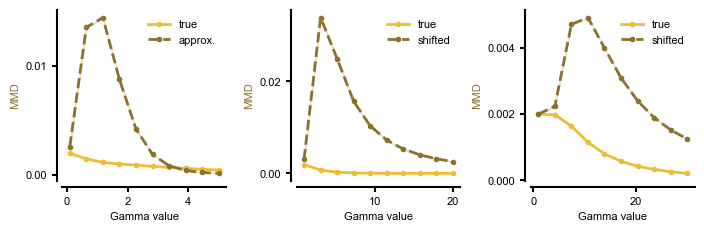

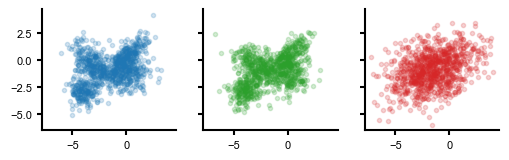

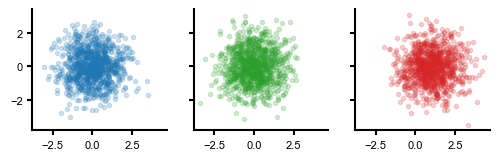

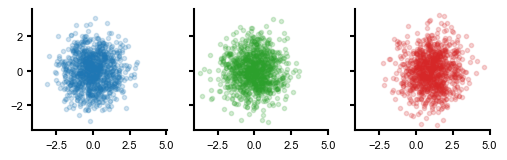

In [7]:
from labproject.data import DATASETS, DISTRIBUTIONS
from labproject.utils import get_cfg, set_seed, get_log_path
from labproject.data import get_dataset
import os
from omegaconf import OmegaConf
from labproject.experiments import *
from labproject.plotting import cm2inch
import time
import datetime
import pickle
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal


print("Running experiments...")
# load the config file
cfg = OmegaConf.load("../../configs/conf_scale_gamma.yaml") 
cfg.running_user = 'MMD_scale_gamma'
seed = cfg.seed

set_seed(seed)
print(f"Seed: {seed}")
print(f"Experiments: {cfg.experiments}") 
print(f"Data: {cfg.data}")


col_dark = {}
col_light = {}
for e, exp_name in enumerate(cfg.experiments):
    col_dark[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='dark')[2]
    col_light[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='light')[-1]

color_list = [col_light, col_dark] # make this a list to account for true and shifted

label_true = {}
label_shift = {}
for e, data_name in enumerate(cfg.data):
    label_true[data_name] = "true"
    label_shift[data_name] = "generated"
    
label_list = [label_true, label_shift]
label_list[1]['toy_2d'] = 'approx.'
label_list[1]['random'] = 'shifted'
mapping = {'ScaleSampleSizeKL':'KL', 'ScaleSampleSizeSW':'SW',
        'ScaleSampleSizeMMD':'MMD', 'ScaleSampleSizeC2ST':'C2ST',
        'ScaleSampleSizeFID':'FD', }

mapping = {'ScaleSampleSizeKL':'KL', 'ScaleSampleSizeSW':'SW',
           'ScaleSampleSizeMMD':'MMD', 'ScaleSampleSizeC2ST':'C2ST',
           'ScaleSampleSizeFID':'FD', 'ScaleDimKL':'KL', 'ScaleDimSW':'SW',
           'ScaleDimMMD':'MMD', 'ScaleDimC2ST':'C2ST',
           'ScaleDimFID':'FD', 'ScaleGammaMMD':'MMD'}

# assert cfg.data is list
assert len(cfg.data) == len(cfg.n) == len(cfg.d), "Data, n and d must be lists of the same length"
    
# make comparison plots
fig, axes = plt.subplots(1, 3, figsize=cm2inch((18, 6)), sharex='col')
for ax in axes.flatten():
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=3)

for dd, ds in enumerate(cfg.data):
    dataset_fn = get_dataset(cfg.data[dd])
    n_samples = cfg.n[dd]
    custom_values = np.linspace(cfg.val_min[dd], cfg.val_max[dd], cfg.val_step[dd])

    dataset_gt = dataset_fn(n_samples, cfg.d[dd])
    dataset_intra = dataset_fn(n_samples, cfg.d[dd])
    
    print(cfg.data[dd], n_samples, cfg.d[dd])
    
    if cfg.data[dd] == 'toy_2d':
        dataset_inter = MultivariateNormal(torch.mean(dataset_gt, axis=0).T,
                                           torch.cov(dataset_gt.T)).sample((n_samples,))
    elif cfg.data[dd] == 'random' and cfg.augmentation[dd]=='mean_shift':
        dataset_inter = dataset_fn(n_samples,cfg.d[dd]) + 1 # just shift the mean by 1
    elif cfg.data[dd] == 'random' and cfg.augmentation[dd]=='one_dim_shift':
        # just shift the first dimension by 0.1
        dataset_inter = dataset_fn(n_samples,cfg.d[dd])
        dataset_inter[:,0] += 1 # just shift the mean of first dim by 1

    fig_data, axes_data = plt.subplots(1, 3, figsize=cm2inch((15, 4)), sharex=True, sharey=True)
    axes_data[0].plot(dataset_gt[:1000, 0], dataset_gt[:1000, 1], 'o', label='gt', alpha=0.2, color='C0')
    axes_data[1].plot(dataset_intra[:1000, 0], dataset_intra[:1000, 1], 'o', label='true',  alpha=0.2, color='C2')
    axes_data[2].plot(dataset_inter[:1000, 0], dataset_inter[:1000, 1], 'o', label='approx' ,alpha=0.2, color='C3')
    
    ax.legend()

    experiment = globals()[exp_name](value_sizes=custom_values)
    time_start = time.time()
    dataset1 = dataset_gt
    ax = axes[dd]
    for dc, data_comp in enumerate([dataset_intra, dataset_inter]):
        dataset2 = data_comp
        assert dataset1.shape == dataset2.shape, f"Dataset shapes do not match: {dataset1.shape} vs. {dataset2.shape}"
        
        output = experiment.run_experiment(dataset1=dataset1,
                                        dataset2=dataset2)
        
        time_end = time.time()
        print(f"Experiment {exp_name} finished in {time_end - time_start}")

        log_path = get_log_path(cfg, tag=f"_{mapping[exp_name]}_{cfg.data[dd]}_{dc}", timestamp=False)
        os.makedirs(os.path.dirname(log_path), exist_ok=True)
        experiment.log_results(output, log_path)
        print(f"Numerical results saved to {log_path}")

        experiment.plot_experiment(*output, cfg.data[dd],
                                ax=ax,
                                color=color_list[dc][exp_name], 
                                label=label_list[dc][cfg.data[dd]],
                                linestyle='-' if dc == 0 else '--',lw=2, marker='o')
    ax.legend()        

axes[-1].set_xlabel('Gamma value')
axes[0].set_xlabel('Gamma value')
axes[1].set_xlabel('Gamma value')

fig.tight_layout()
print(f"Plots saved to {cfg.data}.png")
fig.savefig(f"./results/plots/MMD_scale_gamma.png", dpi=300)
fig.savefig(f"./results/plots/MMD_scale_gamma.pdf", dpi=300)

print("Finished running experiments.")

In [ ]:
plt.plot(value_sizes, final_distances, label='MMD')